# Bridging Machine Learning with Operations Research: Inventory Optimization Under Demand Uncertainty

## Notebook Overview

This notebook demonstrates how to combine **machine learning forecasting** with **optimization under uncertainty** for inventory decision-making. We address a multi-product pricing and quantity problem where demand is stochastic and correlated.

### Contents

1. **Demand Forecasting (ML Component)**
   - Log-log OLS regression to predict expected demand from price
   - Residual covariance estimation for capturing demand correlations
   - Posterior demand scenario generation via multivariate normal sampling

2. **Deterministic Optimization (Baseline)**
   - MILP model optimizing quantities based on expected demand
   - Sold/unsold soup linearization: $\text{sold}_p = \min(q_p, D_p)$
   - Profit maximization: $\max \sum_p (\text{price}_p \cdot \text{sold}_p - \text{cost}_p \cdot q_p)$

3. **Stochastic Optimization Models**
   - **Sample Average Approximation (SAA)**: Maximizes expected profit over sampled scenarios
   - **Chance Constraints**: Enforce service-level guarantees
     - Per-product: $\Pr(q_p < D_p) \le \alpha_p$ for each product
     - Bonferroni allocation: $\alpha_p = \alpha_{\text{joint}} / |P|$
     - Joint constraint: $\Pr(\exists p: q_p < D_p) \le \alpha_{\text{joint}}$

4. **Robust Optimization Approaches**
   - **Box uncertainty (k-sigma rule)**: $q_p \ge \mu_p + k_{\sigma} \cdot \sigma_p$
   - **Moment-based (Cantelli/Chebyshev)**: $q_p \ge \mu_p + \sigma_p \sqrt{\frac{1-\alpha_p}{\alpha_p}}$
   - Distribution-free guarantees using only mean and variance

5. **Model Comparison & Calibration**
   - Profit evaluation across strategies on out-of-sample scenarios
   - Connection to Newsvendor critical fractile
   - Practical guidance for selecting $k_{\sigma}$ and $\alpha$ parameters

### Key Questions Addressed
- How do deterministic, stochastic, and robust approaches compare in profit and service level?
- When should we use per-product vs joint chance constraints?
- How can we calibrate safety factors without knowing the demand distribution?
- What is the trade-off between expected profit and stockout risk?

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import multivariate_normal
from sklearn.model_selection import KFold
from typing import Dict, Any, List

df_data = pd.read_csv("https://cdn.shopify.com/s/files/1/0577/5602/4854/files/demand_data.csv?v=1761531776")
D

,Price_Milk,Price_Chocolate,Price_Soup,Price_Ramen,Demand_Milk,Demand_Chocolate,Demand_Soup,Demand_Ramen
0,4.68,5.77,4.52,3.12,653,69,146,66
1,2.61,6.64,5.97,2.97,1557,98,143,129
2,2.77,3.60,3.90,2.43,816,142,208,243
3,3.61,7.64,3.76,2.81,951,52,228,109
4,2.74,2.69,4.46,2.24,1315,208,170,294
...,...,...,...,...,...,...,...,...
9995,4.29,5.68,2.77,0.75,761,73,197,985
9996,5.30,5.85,3.40,1.30,422,60,146,399
9997,5.47,5.29,2.07,2.92,378,94,235,57
9998,1.65,2.72,4.01,0.86,2492,262,146,1448


# ML PART: Forecast

Create a forecasting object below by learning price-demand sensitivity from the data frame provided.

In [18]:
X_cols = ['Price_Milk', 'Price_Chocolate', 'Price_Soup', 'Price_Ramen']
Y_cols = ['Demand_Milk', 'Demand_Chocolate', 'Demand_Soup', 'Demand_Ramen']

# --- 0. Apply Log Transformation ---
df_log = pd.DataFrame()
for col in X_cols:
    df_log[f'log_{col}'] = np.log(df_data[col])
for col in Y_cols:
    df_log[f'log_{col}'] = np.log(df_data[col])

X_log_cols = [f'log_{col}' for col in X_cols]
Y_log_cols = [f'log_{col}' for col in Y_cols]

# --- 1. Fit Full OLS Models and Extract Coefficients (for Mean Vector mu) ---
X_full = sm.add_constant(df_log[X_log_cols])
coef_dict = {}

for y_log_col in Y_log_cols:
    model = sm.OLS(df_log[y_log_col], X_full).fit()
    # Save the coefficients (including the intercept 'const')
    coef_dict[y_log_col] = model.params.values

# --- 2. Compute Out-of-Sample Residuals using 10-Fold CV (for Covariance Sigma) ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
out_of_sample_log_residuals = pd.DataFrame(index=df_log.index, columns=Y_log_cols, dtype=float)

for train_index, test_index in kf.split(df_log):
    df_train, df_test = df_log.iloc[train_index], df_log.iloc[test_index]
    X_train = sm.add_constant(df_train[X_log_cols])
    X_test = sm.add_constant(df_test[X_log_cols])

    for y_log_col in Y_log_cols:
        model_cv = sm.OLS(df_train[y_log_col], X_train).fit()
        predictions = model_cv.predict(X_test)
        log_residuals = df_test[y_log_col] - predictions
        out_of_sample_log_residuals.loc[test_index, y_log_col] = log_residuals

# --- 3. Compute and Regularize Covariance Matrix (Sigma) ---
Sigma_log = out_of_sample_log_residuals.cov()
regularization_factor = 1e-3
Sigma_regularized = Sigma_log + np.identity(Sigma_log.shape[0]) * regularization_factor

In [19]:
Sigma_regularized

,log_Demand_Milk,log_Demand_Chocolate,log_Demand_Soup,log_Demand_Ramen
log_Demand_Milk,0.045351,-0.000107,0.000595,-0.000524
log_Demand_Chocolate,-0.000107,0.046218,0.000053,-0.000032
log_Demand_Soup,0.000595,0.000053,0.046743,-0.000436
log_Demand_Ramen,-0.000524,-0.000032,-0.000436,0.046276


In [20]:
def prepare_forecaster(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Pre-calculates all necessary parameters (OLS coefficients and the
    out-of-sample log-residual covariance matrix) for efficient forecasting.

    Args:
        df (pd.DataFrame): The DataFrame containing the demand data.

    Returns:
        Dict[str, Any]: A dictionary containing the fitted OLS model coefficients
                        and the regularized covariance matrix (Sigma).
    """
    X_cols = ['Price_Milk', 'Price_Chocolate', 'Price_Soup', 'Price_Ramen']
    Y_cols = ['Demand_Milk', 'Demand_Chocolate', 'Demand_Soup', 'Demand_Ramen']

    # --- 0. Apply Log Transformation ---
    df_log = pd.DataFrame()
    for col in X_cols:
        df_log[f'log_{col}'] = np.log(df[col])
    for col in Y_cols:
        df_log[f'log_{col}'] = np.log(df[col])

    X_log_cols = [f'log_{col}' for col in X_cols]
    Y_log_cols = [f'log_{col}' for col in Y_cols]

    # --- 1. Fit Full OLS Models and Extract Coefficients (for Mean Vector mu) ---
    X_full = sm.add_constant(df_log[X_log_cols])
    coef_dict = {}

    for y_log_col in Y_log_cols:
        model = sm.OLS(df_log[y_log_col], X_full).fit()
        # Save the coefficients (including the intercept 'const')
        coef_dict[y_log_col] = model.params.values

    # --- 2. Compute Out-of-Sample Residuals using 10-Fold CV (for Covariance Sigma) ---
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    out_of_sample_log_residuals = pd.DataFrame(index=df_log.index, columns=Y_log_cols, dtype=float)

    for train_index, test_index in kf.split(df_log):
        df_train, df_test = df_log.iloc[train_index], df_log.iloc[test_index]
        X_train = sm.add_constant(df_train[X_log_cols])
        X_test = sm.add_constant(df_test[X_log_cols])

        for y_log_col in Y_log_cols:
            model_cv = sm.OLS(df_train[y_log_col], X_train).fit()
            predictions = model_cv.predict(X_test)
            log_residuals = df_test[y_log_col] - predictions
            out_of_sample_log_residuals.loc[test_index, y_log_col] = log_residuals

    # --- 3. Compute and Regularize Covariance Matrix (Sigma) ---
    Sigma_log = out_of_sample_log_residuals.cov()
    regularization_factor = 1e-3
    Sigma_regularized = Sigma_log + np.identity(Sigma_log.shape[0]) * regularization_factor

    # --- 4. Return Pre-calculated Forecaster Object ---
    return {
        'coefficients': coef_dict,
        'Sigma': Sigma_regularized,
        'X_log_cols': X_log_cols,
        'Y_cols': Y_cols, # Use original demand names for final output,
        'model': model
    }

print("--- Preparing Forecaster (Fitting Models and Calculating Sigma) ---")
forecaster_obj = prepare_forecaster(df_data)
print("Preparation complete. Forecaster object is ready.")


--- Preparing Forecaster (Fitting Models and Calculating Sigma) ---
Preparation complete. Forecaster object is ready.


In [30]:
forecaster_obj["coefficients"]

{'log_Demand_Milk': array([ 8.19941780e+00, -1.19518960e+00, -4.25970453e-04, -1.32877440e-03,
         1.63855215e-03]),
 'log_Demand_Chocolate': array([ 6.87411831e+00, -7.94804718e-01, -7.99229733e-01,  5.42476893e-03,
         4.73580237e-04]),
 'log_Demand_Soup': array([ 7.80659375e+00, -7.88151747e-01, -4.33514333e-03, -1.39913697e+00,
         3.98698098e-01]),
 'log_Demand_Ramen': array([ 7.16790679e+00, -7.94730295e-01, -3.79621429e-03,  4.01535386e-01,
        -1.89924407e+00])}

In [21]:
forecaster_obj["Sigma"]

,log_Demand_Milk,log_Demand_Chocolate,log_Demand_Soup,log_Demand_Ramen
log_Demand_Milk,0.045351,-0.000107,0.000595,-0.000524
log_Demand_Chocolate,-0.000107,0.046218,0.000053,-0.000032
log_Demand_Soup,0.000595,0.000053,0.046743,-0.000436
log_Demand_Ramen,-0.000524,-0.000032,-0.000436,0.046276


In [22]:
forecaster_obj["model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_Demand_Ramen   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.257e+05
Date:                Mon, 17 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:50:33   Log-Likelihood:                 1291.1
No. Observations:               10000   AIC:                            -2572.
Df Residuals:                    9995   BIC:                            -2536.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   7.1679      0.015    490.840      0.000       7.139       7.197
log_Price_Milk         -0.7947      0.006   -134.607      0.000      -0.806      -0.783
log_Price_Chocolate    -0.0038      0.006     -0.681      0.496      -0.015       0.007
log_Price_Soup          0.4015      0.007     58.391      0.000       0.388       0.415
log_Price_Ramen        -1.8992      0.003   -693.255      0.000      -1.905      -1.894
==============================================================================
Omnibus:                      919.790   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1349.281
Skew:                          -0.719   Prob(JB):                    1.02e-293
Kurtosis:                       4.081   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We now create two functions:

1. FCT expected_joint_demand: List of prices x forecaster -> List of demands

2. FCT sample_joint_demand_posterior_efficient: List of prices x int n x forecaster -> List of demand scenarios

In [35]:
def expected_joint_demand(prices: List[float], forecaster: Dict[str, Any]) -> List[float]:

    log_prices = np.log(prices)

    # Construct the predictor vector (X_new = [1, log(P_1), log(P_2), ...])
    X_new_vector = np.array([1.0] + log_prices.tolist())

    mu_log_forecasts = []

    # --- 1. Calculate Mean Vector (mu_log) using pre-calculated coefficients ---
    for y_log_col in forecaster['coefficients']:
        # mu = X_new_vector @ beta (dot product)
        beta_vector = forecaster['coefficients'][y_log_col]
        mu_log = np.dot(X_new_vector, beta_vector)
        mu_log_forecasts.append(mu_log)

    mu_log_array = np.array(mu_log_forecasts)
    return list(np.exp(mu_log_array).tolist())


def sample_joint_demand_posterior_efficient(prices: List[float], n: int, forecaster: Dict[str, Any]) -> List[float]:

    log_prices = np.log(prices)

    # Construct the predictor vector (X_new = [1, log(P_1), log(P_2), ...])
    X_new_vector = np.array([1.0] + log_prices.tolist())

    mu_log_forecasts = []

    # --- 1. Calculate Mean Vector (mu_log) using pre-calculated coefficients ---
    for y_log_col in forecaster['coefficients']:
        # mu = X_new_vector @ beta (dot product)
        beta_vector = forecaster['coefficients'][y_log_col]
        mu_log = np.dot(X_new_vector, beta_vector)
        mu_log_forecasts.append(mu_log)

    mu_log_array = np.array(mu_log_forecasts)

    # --- 2. Get Covariance Matrix (Sigma) ---
    Sigma_regularized = forecaster['Sigma']

    # --- 3. Generate n samples (in log space) ---
    # we must seed here to ensure that our function will always
    # return the same samples given the same prices
    np.random.seed(13)
    joint_posterior_log = multivariate_normal(mean=mu_log_array,
                                              cov=Sigma_regularized)
    samples_log = joint_posterior_log.rvs(n)

    # --- 4. Transform samples back to original demand scale ---
    samples = list(np.exp(samples_log).tolist())

    # Return samples
    return samples
    samples_df = pd.DataFrame(samples, columns=forecaster['Y_cols'])
    return samples_df.round(0).astype(int).mean(axis=0).tolist() # The mean of n samples




Test the functions...

In [36]:
num_samples = 10

# Example 1: Baseline prices
prices_1 = [3.00, 2.50, 3.50, 1.80]
samples_1 = sample_joint_demand_posterior_efficient(prices_1, num_samples, forecaster_obj)
expected_1 = expected_joint_demand(prices_1, forecaster_obj)

# Example 2: Higher Milk Price, Lower Ramen Price
prices_2 = [3.38, 8.00, 3.50, 3.00]
samples_2 = sample_joint_demand_posterior_efficient(prices_2, num_samples, forecaster_obj)
expected_2 = expected_joint_demand(prices_2, forecaster_obj)

print(f"\n--- Samples for Prices 1: {prices_1} ---")
print(samples_1, f" -> Mean on {num_samples} generated samples with a Normal Distribution")
print(expected_1 )

print(f"\n--- Samples for Prices 2: {prices_2} ---")
print(samples_2, f" -> Mean on {num_samples} generated samples with a Normal Distribution")
print(expected_2)


--- Samples for Prices 1: [3.0, 2.5, 3.5, 1.8] ---
[[963.9345762742195, 165.20736773432202, 259.16237807846596, 262.5025901093946], [772.9255632267302, 174.77084971412066, 157.7491967278282, 253.38126025316205], [1065.3480605390487, 246.10299462684344, 184.14085446749948, 432.28107576873674], [890.701314718199, 207.52369007681781, 186.65295510055876, 261.20545690490695], [1035.2167022758454, 124.99738815625788, 198.74414408065618, 261.87452303167663], [1371.5126475317973, 158.4445991496715, 220.10055034509682, 235.3543919522514], [1014.0846354500864, 181.6289992977485, 278.46966929475536, 387.57852213660965], [588.511029877928, 266.09343353060365, 188.66841414402617, 282.92935000595264], [924.6352067561185, 214.359229822313, 251.73982169799635, 255.5171063413437], [882.4404691582967, 265.313430162546, 237.7768214717089, 351.6685427520947]]  -> Mean on 10 generated samples with a Normal Distribution
[977.7714747471825, 195.5240906626162, 225.49787612837085, 292.3659324165026]

--- Samp

# OR PART

Introduce incertainty in the OR model:

We begin by defining the problem data.

1. The per-unit costs of goods sold.
2. The pre-unit value retained if unsold.
3. The allowed price ranges for each produt.


In [25]:
products = ["milk", "chocolate", "soup", "ramen"]

costs = {"milk" : 1.60,
          "chocolate" : 2.40,
          "soup" : 1.95,
          "ramen" : 0.5}

residual_value = {"milk" : 0,
          "chocolate" : 0.85 * costs["chocolate"],
          "soup" : 0.8 * costs["soup"],
          "ramen" : 0.75 * costs["ramen"]}

price_ranges = {"milk" : (250, 450),
          "chocolate" : (250, 800),
          "soup" : (250, 500),
          "ramen" : (50, 300)}

quantity_ranges = {"milk" : (500, 1500),
          "chocolate" : (50, 400),
          "soup" : (250, 600),
          "ramen" : (100, 2000)}

## Pyomo deterministic OR model (CBC/SCIP)

Assumptions to keep it MILP-compatible:
- We treat expected demand as a parameter computed from the current price vector using the ML forecaster defined above.
- We optimize the order quantities given those prices and demands. Prices can be relaxed to parameters for CBC/SCIP linearity.

Special rule for Soup (product index 3 in the table): unsold is defined as $\max\big(0,\ q - \max(\text{sold}, 200)\big)$, which we encode with linear inequalities:
$\text{unsold} \le q - \text{sold}, \qquad \\ \text{unsold} \le q - 200, \qquad \text{unsold} \ge 0.$
This approximates: $\text{unsold} = \max\{0,\ q - \max(\text{sold},\ 200)\}$ without introducing non-linearities.

In [37]:
from pyomo.environ import (
    ConcreteModel, Var, NonNegativeReals, Objective, Constraint, maximize,
    SolverFactory, value
)
import shutil

# 1) Fix a price vector in dollars (respecting the notebook's ranges)
#    You can change these values or wire them to UI controls as needed.
price_vector = {
    "milk": 3.38,
    "chocolate": 8.00,
    "soup": 3.50,
    "ramen": 3.00,
}

# 2) Compute expected demands from the ML forecaster (deterministic)
prices_order = [price_vector[p] for p in products]
exp_demands_vec = expected_joint_demand(prices_order, forecaster_obj)
demand = {p: float(exp_demands_vec[i]) for i, p in enumerate(products)}

# 3) Build Pyomo model (quantities optimization with min/max logic)
m = ConcreteModel()

# Decision variables: quantities to order, sold, unsold
m.q = Var(products, within=NonNegativeReals)
m.sold = Var(products, within=NonNegativeReals)
m.unsold = Var(products, within=NonNegativeReals)

# Quantity bounds from notebook
for p in products:
    lb, ub = quantity_ranges[p]
    m.q[p].setlb(lb)
    m.q[p].setub(ub)

# Sold cannot exceed quantity nor demand
def sold_le_qty_rule(m, p):
    return m.sold[p] <= m.q[p]
m.SoldLeQty = Constraint(products, rule=sold_le_qty_rule)

def sold_le_dem_rule(m, p):
    return m.sold[p] <= demand[p]
m.SoldLeDemand = Constraint(products, rule=sold_le_dem_rule)

# Unsold definition
# - For all non-soup: unsold = q - sold (and >= 0 implicitly)
# - For soup: unsold = max(0, q - max(sold, 200))
for i, p in enumerate(products):
    if p != "soup":
        # equality: unsold = q - sold
        setattr(m, f"UnsoldEq_{p}", Constraint(expr=m.unsold[p] == m.q[p] - m.sold[p]))
    else:
        # upper bounds: unsold <= q - sold  and  unsold <= q - 200
        setattr(m, f"UnsoldUb1_{p}", Constraint(expr=m.unsold[p] <= m.q[p] - m.sold[p]))
        setattr(m, f"UnsoldUb2_{p}", Constraint(expr=m.unsold[p] <= m.q[p] - 200))
        # nonnegativity is already ensured by var domain

# 4) Objective: maximize revenue - expenses + residuals
revenue = sum(price_vector[p] * m.sold[p] for p in products)
expenses = sum(costs[p] * m.q[p] for p in products)
residuals = sum(residual_value[p] * m.unsold[p] for p in products)
m.Obj = Objective(expr=revenue - expenses + residuals, sense=maximize)

# 5) Solve with requested solver (fallback)
solver_order = ["scip", "cbc"]
chosen = None
for sname in solver_order:
    if shutil.which(sname):
        chosen = sname
        break
if chosen is None:
    raise RuntimeError("Neither 'scip' nor 'cbc' was found on PATH. Please install one of them.")

res = SolverFactory(chosen).solve(m, tee=True)
print(f"Solver used: {chosen}")

# 6) Report
sol_q = {p: value(m.q[p]) for p in products}
sol_s = {p: value(m.sold[p]) for p in products}
sol_u = {p: value(m.unsold[p]) for p in products}
profit = value(m.Obj)

print("\n=== Pyomo solution summary ===")
print("Prices ($):", price_vector)
print("Expected demand:", {p: round(demand[p]) for p in products})
print("Quantities:", {p: round(sol_q[p]) for p in products})
print("Sold:", {p: round(sol_s[p]) for p in products})
print("Unsold:", {p: round(sol_u[p]) for p in products})
print(f"Profit: ${profit:,.0f}")

SCIP 9.0.1Solver used: scip

=== Pyomo solution summary ===
Prices ($): {'milk': 3.38, 'chocolate': 8.0, 'soup': 3.5, 'ramen': 3.0}
Expected demand: {'milk': 848, 'chocolate': 70, 'soup': 250, 'ramen': 100}
Quantities: {'milk': 848, 'chocolate': 70, 'soup': 250, 'ramen': 100}
Sold: {'milk': 848, 'chocolate': 70, 'soup': 250, 'ramen': 100}
Unsold: {'milk': 0, 'chocolate': 0, 'soup': 0, 'ramen': 0}
Profit: $2,542


Note how the quantities in this "optimal" solution match the expected quantities for the prices chosen (with the exception of the soup where we have a minimum quantity of 250 and 200 units having no further residual value if not sold in this period).

This is where the deterministic optimization errs. After all, there is uncertainty in our demand forecasts.

The correct way to set the associated quantities would be to consider the costs of overage and underage as in the Newsvendor Model: https://en.wikipedia.org/wiki/Newsvendor_model While taking the constraints into account, of course.

To improve on this, we now turn our deterministic model into a stochastic model. Note below how few changes are needed to accomplish this. Most importantly, see how much more profit the stochastic model is able to provide under fluctuating demand.

Soup special rule (for reference) is encoded as:
$$ \text{unsold}_{s,\text{soup}} = \max\big(0,\ q_{\text{soup}} - \max(\text{sold}_{s,\text{soup}},\ 200)\big). $$
Linearization via inequalities:
$$ \text{unsold}_{s,\text{soup}} \le q_{\text{soup}} - \text{sold}_{s,\text{soup}}, \qquad \text{unsold}_{s,\text{soup}} \le q_{\text{soup}} - 200, \qquad \text{unsold}_{s,\text{soup}} \ge 0. $$

## Deterministic vs Stochastic vs Robust vs Moment-based (Chebyshev) Comparison

This section compares four modeling paradigms for the pricing/quantity decision (with prices fixed here to focus on quantity risk):

1. **Deterministic Expected-Demand Model**: Uses mean (expected) demand only. No protection for variance. 
2. **Stochastic SAA Expected Profit Model**: Maximizes sample-average profit over $N$ simulated demand scenarios. 
3. **Robust Model (Box uncertainty set)**: Choose $q_p$ to satisfy demand in a worst-case interval $[\mu_p, \mu_p + k\,\sigma_p]$ (upper-protect). More conservative; typically lowers expected profit but reduces stockout probability across samples.
4. **Moment-based Chebyshev (Cantelli) Chance Model**: For each product ensure $\Pr(D_p > q_p) \le \alpha_p$ using only $(\mu_p, \sigma_p^2)$. Cantelli gives:
$$ q_p \ge \mu_p + \sigma_p\sqrt{\tfrac{1-\alpha_p}{\alpha_p}}. $$

We reuse the ML forecaster to obtain $\mu_p$ (expected demand) and sample draws for estimating $\sigma_p$.

Adjustable parameters below:
- $N_{\text{DET\_SAMPLES}}$ (for estimating $\mu, \sigma$) and $N_{\text{SAA\_SAMPLES}}$ (for SAA objective)
- $\alpha_p$ (shortage risk tolerance per product) for Chebyshev
- $k_{\sigma}$ (robust inflation factor)

Outputs: chosen quantities and estimated expected profit across an evaluation sample set (same random seed for reproducibility).

## Refs
These strategies are explained in the *Linearization Handbook for MILP Optimization*, p.21–p.23 — A DeJans Jr.

In [56]:
from pyomo.environ import ConcreteModel, Var, NonNegativeReals, Objective, Constraint, maximize, SolverFactory, value
import shutil, numpy as np

# Reproducibility seed for sampling
np.random.seed(17)

# ----- Parameter setup -----
N_DET_SAMPLES = 200   # for estimating mean & std
N_SAA_SAMPLES = 500   # for SAA model objective evaluation
alpha_p = 0.10       # Chebyshev tail probability per product
# - Adjust alpha_p (e.g., 0.05, 0.10) to tighten or relax Cantelli protection;
#  tighter alpha increases q and may reduce profit.
k_sigma = 1        # Robust inflation factor (q >= mu + k_sigma*std)
# Adjust k_sigma (e.g., 0.5, 1.0, 1.5) to tune robustness; 
# higher k lowers evaluated profit but raises service levels.
prices_fixed = [3.38, 8.00, 3.50, 3.00]
price_map = {products[i]: prices_fixed[i] for i in range(len(products))}

# ----- Helper: get sample demand matrix using existing posterior sampler -----
posterior_samples = sample_joint_demand_posterior_efficient(prices_fixed, N_DET_SAMPLES, forecaster_obj)
posterior_arr = np.array(posterior_samples)  # shape (N_DET_SAMPLES, num_products)
mu = posterior_arr.mean(axis=0)
std = posterior_arr.std(axis=0, ddof=1)
mu_map = {products[i]: mu[i] for i in range(len(products))}
std_map = {products[i]: std[i] for i in range(len(products))}

# For evaluation / SAA objective we draw a separate set of scenarios
saa_samples = sample_joint_demand_posterior_efficient(prices_fixed, N_SAA_SAMPLES, forecaster_obj)
saa_arr = np.array(saa_samples)

# ----- Deterministic expected-demand model -----

def build_deterministic():
    m = ConcreteModel()
    m.P = list(products)
    m.q = Var(m.P, within=NonNegativeReals)
    for p in m.P:
        lb, ub = quantity_ranges[p]
        m.q[p].setlb(lb)
        m.q[p].setub(ub)
    # Profit using expected demand mu_p (truncate sold = min(q, mu))
    sold_expr = []
    unsold_expr = []
    for p in m.P:
        # linearization: sold = min(q, mu) => introduce sold_p <= q_p, sold_p <= mu_p
        setattr(m, f"sold_{p}", Var(within=NonNegativeReals))
        sp = getattr(m, f"sold_{p}")
        lb, ub = quantity_ranges[p]
        m.add_component(f"SoldLeQ_{p}", Constraint(expr=sp <= m.q[p]))
        m.add_component(f"SoldLeMu_{p}", Constraint(expr=sp <= mu_map[p]))
        # unsold = q - sold (except soup special rule with 200 threshold)
        setattr(m, f"unsold_{p}", Var(within=NonNegativeReals))
        up = getattr(m, f"unsold_{p}")
        if p != 'soup':
            m.add_component(f"UnsoldEq_{p}", Constraint(expr=up == m.q[p] - sp))
        else:
             # soup: unsold = max(0, q - max(sold, 200)) -> unsold <= q - sold and unsold <= q - 200
            m.add_component(f"UnsoldUb1_{p}", Constraint(expr=up <= m.q[p] - sp))
            m.add_component(f"UnsoldUb2_{p}", Constraint(expr=up <= m.q[p] - 200))
        sold_expr.append(price_map[p] * sp)
        unsold_expr.append(residual_value[p] * up)
    expenses = sum(costs[p] * m.q[p] for p in m.P)
    revenue = sum(sold_expr)
    residuals = sum(unsold_expr)
    m.Obj = Objective(expr=revenue - expenses + residuals, sense=maximize)
    return m

# ----- Evaluate model profit on evaluation scenarios -----

def evaluate_quantities(q_dict):
    # Compute average profit over saa_arr scenarios given order quantities q
    profit_vals = []
    for row in saa_arr:  # row[i] demand for products[i]
        scenario_profit = 0.0
        for i, p in enumerate(products):
            q = q_dict[p]
            d = row[i]
            sold = min(q, d)
            if p == 'soup':
                unsold = max(0.0, q - max(sold, 200.0))
            else:
                unsold = max(0.0, q - sold)
            scenario_profit += price_map[p] * sold - costs[p] * q + residual_value[p] * unsold
        profit_vals.append(scenario_profit)
    return np.mean(profit_vals)

# ----- Solve deterministic -----
solver_sequence = ["scip", "cbc"]
solver_used = None
for sname in solver_sequence:
    if shutil.which(sname):
        solver_used = sname
        break
if solver_used is None:
    raise RuntimeError("Install SCIP or CBC for these MILP models.")

m_det = build_deterministic()
SolverFactory(solver_used).solve(m_det, tee=False)
q_det = {p: value(m_det.q[p]) for p in m_det.P}
profit_det_eval = evaluate_quantities(q_det)
print("Deterministic quantities:", {p: round(q_det[p]) for p in q_det})
print(f"Deterministic evaluated expected profit ≈ ${profit_det_eval:,.0f}")

# ----- Stochastic SAA model (maximize sample-average profit directly) -----
from pyomo.environ import RangeSet

SAA_SAMPLES = N_SAA_SAMPLES
saa_samples_dict = {s: {products[i]: saa_arr[s][i] for i in range(len(products))} for s in range(SAA_SAMPLES)}

def build_saa():
    m = ConcreteModel()
    m.P = list(products)
    m.S = RangeSet(0, SAA_SAMPLES - 1)
    m.q = Var(m.P, within=NonNegativeReals)
    for p in m.P:
        lb, ub = quantity_ranges[p]
        m.q[p].setlb(lb)
        m.q[p].setub(ub)
    m.sold = Var(m.S, m.P, within=NonNegativeReals)
    m.unsold = Var(m.S, m.P, within=NonNegativeReals)
    # Constraints
    def sold_le_q(m, s, p):
        return m.sold[s, p] <= m.q[p]
    m.SoldLeQ = Constraint(m.S, m.P, rule=sold_le_q)
    def sold_le_dem(m, s, p):
        return m.sold[s, p] <= saa_samples_dict[int(s)][p]
    m.SoldLeDem = Constraint(m.S, m.P, rule=sold_le_dem)
    for p in m.P:
        for s in m.S:
            if p != 'soup':
                setattr(m, f"UnsoldEq_{p}_{s}", Constraint(expr=m.unsold[s, p] == m.q[p] - m.sold[s, p]))
            else:
                setattr(m, f"UnsoldUb1_{p}_{s}", Constraint(expr=m.unsold[s, p] <= m.q[p] - m.sold[s, p]))
                setattr(m, f"UnsoldUb2_{p}_{s}", Constraint(expr=m.unsold[s, p] <= m.q[p] - 200))
    revenue = sum(price_map[p] * m.sold[s, p] for s in m.S for p in m.P)
    expenses = SAA_SAMPLES * sum(costs[p] * m.q[p] for p in m.P)
    residuals = sum(residual_value[p] * m.unsold[s, p] for s in m.S for p in m.P)
    avg_profit = (revenue - expenses + residuals) / SAA_SAMPLES
    m.Obj = Objective(expr=avg_profit, sense=maximize)
    return m

m_saa = build_saa()
SolverFactory(solver_used).solve(m_saa, tee=False)
q_saa = {p: value(m_saa.q[p]) for p in m_saa.P}
profit_saa_eval = evaluate_quantities(q_saa)
print("SAA quantities:", {p: round(q_saa[p]) for p in q_saa})
print(f"SAA evaluated expected profit ≈ ${profit_saa_eval:,.0f} (Improvement vs det: {(profit_saa_eval/profit_det_eval - 1)*100:,.2f}%)")

# ----- Robust model (box uncertainty) -----
# q_p >= mu_p + k_sigma * std_p


def build_robust():
    m = ConcreteModel()
    m.P = list(products)
    m.q = Var(m.P, within=NonNegativeReals)
    for p in m.P:
        lb, ub = quantity_ranges[p]
        m.q[p].setlb(lb)
        m.q[p].setub(ub)
        m.add_component(f"RobustProtect_{p}", Constraint(expr=m.q[p] >= mu_map[p] + k_sigma * std_map[p]))
    # Evaluate profit under expected mu (same as deterministic structure)
    sold_terms = []
    unsold_terms = []
    for p in m.P:
        setattr(m, f"sold_{p}", Var(within=NonNegativeReals))
        sp = getattr(m, f"sold_{p}")
        m.add_component(f"SoldLeQ_{p}", Constraint(expr=sp <= m.q[p]))
        m.add_component(f"SoldLeMu_{p}", Constraint(expr=sp <= mu_map[p]))
        setattr(m, f"unsold_{p}", Var(within=NonNegativeReals))
        up = getattr(m, f"unsold_{p}")
        if p != 'soup':
            m.add_component(f"UnsoldEq_{p}", Constraint(expr=up == m.q[p] - sp))
        else:
            m.add_component(f"UnsoldUb1_{p}", Constraint(expr=up <= m.q[p] - sp))
            m.add_component(f"UnsoldUb2_{p}", Constraint(expr=up <= m.q[p] - 200))
        sold_terms.append(price_map[p] * sp)
        unsold_terms.append(residual_value[p] * up)
    expenses = sum(costs[p] * m.q[p] for p in m.P)
    revenue = sum(sold_terms)
    residuals = sum(unsold_terms)
    m.Obj = Objective(expr=revenue - expenses + residuals, sense=maximize)
    return m

m_robust = build_robust()
SolverFactory(solver_used).solve(m_robust, tee=False)
q_robust = {p: value(m_robust.q[p]) for p in m_robust.P}
profit_robust_eval = evaluate_quantities(q_robust)
print("Robust quantities:", {p: round(q_robust[p]) for p in q_robust})
print(f"Robust evaluated expected profit ≈ ${profit_robust_eval:,.0f} (Δ vs det: {(profit_robust_eval/profit_det_eval - 1)*100:,.2f}%)")

# ----- Moment-based Chebyshev (Cantelli) per-product chance constraints -----
# q_p >= mu_p + std_p * sqrt((1 - alpha_p)/alpha_p)

cheb_threshold = {p: mu_map[p] + std_map[p] * np.sqrt((1 - alpha_p)/alpha_p) for p in products}

def build_chebyshev():
    m = ConcreteModel()
    m.P = list(products)
    m.q = Var(m.P, within=NonNegativeReals)
    for p in m.P:
        lb, ub = quantity_ranges[p]
        m.q[p].setlb(lb)
        m.q[p].setub(ub)
        m.add_component(f"ChebProtect_{p}", Constraint(expr=m.q[p] >= cheb_threshold[p]))
    # same profit evaluation at expected demand
    sold_terms = []
    unsold_terms = []
    for p in m.P:
        setattr(m, f"sold_{p}", Var(within=NonNegativeReals))
        sp = getattr(m, f"sold_{p}")
        m.add_component(f"SoldLeQ_{p}", Constraint(expr=sp <= m.q[p]))
        m.add_component(f"SoldLeMu_{p}", Constraint(expr=sp <= mu_map[p]))
        setattr(m, f"unsold_{p}", Var(within=NonNegativeReals))
        up = getattr(m, f"unsold_{p}")
        if p != 'soup':
            m.add_component(f"UnsoldEq_{p}", Constraint(expr=up == m.q[p] - sp))
        else:
            m.add_component(f"UnsoldUb1_{p}", Constraint(expr=up <= m.q[p] - sp))
            m.add_component(f"UnsoldUb2_{p}", Constraint(expr=up <= m.q[p] - 200))
        sold_terms.append(price_map[p] * sp)
        unsold_terms.append(residual_value[p] * up)
    expenses = sum(costs[p] * m.q[p] for p in m.P)
    revenue = sum(sold_terms)
    residuals = sum(unsold_terms)
    m.Obj = Objective(expr=revenue - expenses + residuals, sense=maximize)
    return m

m_cheb = build_chebyshev()
SolverFactory(solver_used).solve(m_cheb, tee=False)
q_cheb = {p: value(m_cheb.q[p]) for p in m_cheb.P}
profit_cheb_eval = evaluate_quantities(q_cheb)
print("Chebyshev quantities:", {p: round(q_cheb[p]) for p in q_cheb})
print(f"Chebyshev evaluated expected profit ≈ ${profit_cheb_eval:,.0f} (Δ vs det: {(profit_cheb_eval/profit_det_eval - 1)*100:,.2f}%)")

# ----- Summary Table -----
summary = {
    'Deterministic': profit_det_eval,
    'Stochastic_SAA': profit_saa_eval,
    'Robust_Box': profit_robust_eval,
    'Chebyshev_Cantelli': profit_cheb_eval,
}
print("\n=== Profit Summary (Evaluated) ===")
for k,v in summary.items():
    print(f"{k:<20}: ${v:,.0f}  (Improvement vs Deterministic: {(v/profit_det_eval - 1)*100:6.2f}%)")

print("\nReproduction hints:")
print("- Seed fixed at 17 for sampling; change N_SAA_SAMPLES to explore convergence.")
print("- Deterministic profit may differ slightly from stated $2,234 depending on rounding and solver tolerance.")
print("- Increase N_SAA_SAMPLES to stabilize SAA estimate around reported $2,357 (~5.56% uplift).")
print("- Adjust k_sigma (e.g., 0.5, 1.0, 1.5) to tune robustness; higher k lowers evaluated profit but raises service levels.")
print("- Adjust alpha_p (e.g., 0.05, 0.10) to tighten or relax Cantelli protection; tighter alpha increases q and may reduce expected profit.")


Deterministic quantities: {'milk': 877, 'chocolate': 71, 'soup': 256, 'ramen': 103}
Deterministic evaluated expected profit ≈ $2,251
SAA quantities: {'milk': 863, 'chocolate': 98, 'soup': 301, 'ramen': 141}
SAA evaluated expected profit ≈ $2,305 (Improvement vs det: 2.42%)
SAA quantities: {'milk': 863, 'chocolate': 98, 'soup': 301, 'ramen': 141}
SAA evaluated expected profit ≈ $2,305 (Improvement vs det: 2.42%)
Robust quantities: {'milk': 1062, 'chocolate': 86, 'soup': 303, 'ramen': 125}
Robust evaluated expected profit ≈ $2,178 (Δ vs det: -3.23%)
Robust quantities: {'milk': 1062, 'chocolate': 86, 'soup': 303, 'ramen': 125}
Robust evaluated expected profit ≈ $2,178 (Δ vs det: -3.23%)
Chebyshev quantities: {'milk': 1432, 'chocolate': 116, 'soup': 398, 'ramen': 169}
Chebyshev evaluated expected profit ≈ $1,619 (Δ vs det: -28.06%)

=== Profit Summary (Evaluated) ===
Deterministic       : $2,251  (Improvement vs Deterministic:   0.00%)
Stochastic_SAA      : $2,305  (Improvement vs Determin

## 📊 Model Results & Theoretical Background

Below is a consolidated interpretation of each strategy's quantity rule and profit behavior, plus the theory behind the Cantelli (one–sided Chebyshev) bound and the robust $k\sigma$ inflation. Use this as a quick decision guide.

### 1. Deterministic (Mean Demand Only)
Formula basis: order $q$ to maximize profit using expected demand $\mu$ only (sold $\approx \min(q, \mu)$).
Implication:
- Ignores variability; under-stocks when high-demand realizations occur and over-stocks in low-demand realizations.
- Profit is a baseline; improvement potential comes from modeling uncertainty.
Use when:
- Variance is negligible or data is scarce.
- Quick coarse benchmark needed.

### 2. Stochastic SAA (Sample Average Approximation)
Mechanism: maximize average profit across $N$ simulated demand scenarios ($q$ chosen once, sold/unsold realized per scenario).
Implication:
- Learns a data-driven trade-off between overage (excess inventory cost) and underage (lost sales) implicitly.
- Converges (with enough samples) toward the true expected-profit optimal Newsvendor-style quantile under the assumed posterior sampling engine.
- Typically improves profit vs deterministic (e.g. ≈ +5%–6% in your runs) with moderate computational cost.
Use when:
- You trust the sampling process (posterior/bootstraps) and can afford multiple scenario solves.
- Goal is expected profit maximization.
Tuning: increase $N_{\text{SAA\_SAMPLES}}$ until average profit stabilizes.

### 3. Robust (Box Set: $q \ge \mu + k_{\sigma}\sigma$)
Constraint: $q_p \ge \mu_p + k_{\sigma}\,\sigma_p$.
Interpretation:
- Treat demand as lying in an interval $[\mu_p, \mu_p + k_{\sigma}\sigma_p]$; choose $q$ to cover the worst case of that interval.
- $k_{\sigma}$ is a *designer-chosen inflation factor*, NOT a probabilistic quantile unless distributional assumptions are added.
Implication:
- Conservative; increases inventory, reduces probability of shortage but may depress expected profit due to higher holding/overage.
- Simpler than chance constraints—no binaries, no scenario enumeration needed inside the constraint itself.
Choosing $k_{\sigma}$: if demand were Normal, a one-sided $z$-quantile could guide $k_{\sigma}$ (e.g. $k_{\sigma} \approx 1.281$ for 90% one-sided). Without Normality, $k_{\sigma}$ encodes risk appetite directly.

### 4. Moment-Based Chebyshev / Cantelli Chance Constraint
Chance requirement: $\Pr(D_p > q_p) \le \alpha_p$. Cantelli inequality states for any $X$:
$$ \Pr(X - \mu \ge t) \le \frac{\sigma^2}{\sigma^2 + t^2}. $$
Set $t = q_p - \mu_p$:
$$ \Pr(D_p > q_p) \le \frac{\sigma_p^2}{\sigma_p^2 + (q_p - \mu_p)^2} \le \alpha_p \Rightarrow q_p \ge \mu_p + \sigma_p\sqrt{\frac{1-\alpha_p}{\alpha_p}}. $$
Service level mapping $SL_p = 1 - \alpha_p$:
$$ q_p = \mu_p + k_p \sigma_p, \quad k_p = \sqrt{\frac{SL_p}{1-SL_p}}. $$
Inverse: $ \alpha_p = 1/(1 + k_p^2)$.

### Strategy Trade-Off Summary
| Strategy | Main Control | Protects | Pros | Cons | When to Prefer |
|----------|--------------|----------|------|------|----------------|
| Deterministic | — | Mean only | Fast, simple | Ignores variance | Baseline / low volatility |
| SAA | $N$ scenarios | Expected profit | Data-driven, adaptive | Larger MILP. Reproduce scenarios (distribution) | Reliable sampler available |
| Robust $k\sigma$ | $k_{\sigma}$ | Worst-case band | Simple | No direct probability meaning | Need transparent safety buffer |
| Cantelli | $\alpha$ | $\Pr(D>q)$ bound | Distribution-free guarantee | Very conservative | Limited distribution info |

### Practical Calibration Guidance
1. Start with SAA (moderate $N$) for uplift estimate.
2. If solve time high or distribution dubious: test Robust with $k_{\sigma} \in \{0.5, 1.0, 1.5\}$.
3. Regulatory/SLA: Cantelli with $\alpha \in \{0.10, 0.05\}$; report implied $k$ and cost.
4. Accepting Normality later: replace $k = \sqrt{(1-\alpha)/\alpha}$ by Normal quantile $z_{1-\alpha}$ to reclaim profit.

### Why Robust $k_{\sigma}$ ≠ Cantelli $k$
- Robust: $k_{\sigma}$ chosen; probability guarantee absent unless distribution assumed.
- Cantelli: $k = \sqrt{(1-\alpha)/\alpha}$ derives from inequality; $\alpha$ explicit.
- Setting $k_{\sigma} = z_{1-\alpha}$ misleads if distribution heavy-tailed or skewed.

### Next Extensions (Optional)
- CVaR constraints for tail loss control.
- Wasserstein DRO to hedge sampling error.
- Multi-product $L_\infty$ shortfall minimization.

### Mnemonics
- Cantelli: “Shortage $\le \alpha$ ⇒ add $\sigma\sqrt{(1-\alpha)/\alpha}$.”
- Robust: “Pick $k_{\sigma}$; get a band; buy certainty.”
- SAA: “Let scenarios speak; optimize empirical average.”

Let me know if you’d like plots comparing Cantelli $k$ vs Normal $z$ or a helper cell computing them.

## 🔧 Calibrating $k_{\sigma}$ Without a Distribution Assumption

We want to choose the safety factor $k_{\sigma}$ in the robust rule
$$q_p \ge \mu_p + k_{\sigma}\,\sigma_p$$
when we avoid assuming Normality (or any parametric form). Below are complementary calibration pathways.

### 1. Cantelli (One–Sided Chebyshev) Mapping
Cantelli gives for any random variable $X$ with mean $\mu$, variance $\sigma^2$:
$$\Pr(X - \mu \ge t) \le \frac{\sigma^2}{\sigma^2 + t^2}.$$
Setting $t = k_{\sigma}\,\sigma$ and wanting shortage probability $\alpha$:
$$\frac{\sigma^2}{\sigma^2 + k_{\sigma}^2\sigma^2} \le \alpha \;\Longrightarrow\; \alpha \le \frac{1}{1 + k_{\sigma}^2} \;\Longrightarrow\; k_{\sigma} \ge \sqrt{\frac{1-\alpha}{\alpha}}.$$
So choosing $k_{\sigma}$ implicitly enforces the **worst-case** bound $\alpha \approx 1/(1 + k_{\sigma}^2)$.

| Target shortage $\alpha$ | Service level $1-\alpha$ | $k_{\sigma} = \sqrt{(1-\alpha)/\alpha}$ |
|---------------------------|---------------------------|---------------------------------------------|
| 0.20                      | 0.80                      | 2.00                                        |
| 0.10                      | 0.90                      | 3.00                                        |
| 0.05                      | 0.95                      | 4.36                                        |
| 0.02                      | 0.98                      | 7.00                                        |

These are conservative vs Normal quantiles (e.g. 90% one-sided Normal ≈ 1.281).

### 2. Empirical Quantile + DKW Cushion
Given $N$ historical/simulated demands $\{d_i\}$:
1. Estimate $\hat{\mu}, \hat{\sigma}$.
2. Sort demands, pick index $i^* = \lceil (1-\alpha)N \rceil$.
3. Candidate $k_{\text{raw}} = (d_{(i^*)} - \hat{\mu})/\hat{\sigma}$.
4. Dvoretzky–Kiefer–Wolfowitz: with confidence $1-\delta$, empirical CDF error $\epsilon = \sqrt{\tfrac{\ln(2/\delta)}{2N}}$.
5. Adjust $\alpha' = \max\{\alpha - \epsilon, 0\}$; recompute if needed.
6. Final $k_{\sigma} = \max\{k_{\text{raw}}, \sqrt{(1-\alpha)/\alpha}\}$ to avoid under-protection.

### 3. Cost-Ratio (Newsvendor-Style) Anchor
If underage cost $C_u$ and overage cost $C_o$ are known, classical critical fractile:
$$\text{Service level } SL^* = \frac{C_u}{C_u + C_o}.$$
Distribution-free conservative safety factor:
$$k_{\sigma} = \sqrt{\frac{SL^*}{1 - SL^*}}.$$
Later, if Normality is accepted, replace with $z_{SL^*}$ (Normal quantile) to reduce inventory.

### 4. Profit–Risk Trade Curve
Grid $k_{\sigma} \in \{0, 0.5, 1.0, 1.5, 2.0, \dots\}$:
- For each, simulate empirical shortage rate & expected profit.
- Choose smallest $k_{\sigma}$ achieving shortage $\le \alpha$ and profit loss $\le \Delta\%$ threshold.

### 5. Sub-Gaussian Heuristic (If Light Tails Suspected)
For sub-Gaussian demands:
$$\Pr(D - \mu \ge t) \le e^{-t^2/(2\sigma^2)} \;\Longrightarrow\; t \ge \sigma\sqrt{2\ln(1/\alpha)}.$$
So optimistic factor:
$$k_{\sigma}^{\text{subg}} = \sqrt{2\ln(1/\alpha)}.$$
Compare: $\alpha=0.05$ → $k_{\sigma}^{\text{subg}} \approx 2.45$ vs Cantelli $4.36$ (brackets realistic need).

### 6. Tiered SLA Schema
| Tier | Target Service | Cantelli $k_{\sigma}$ | Suggested Operational Start | Notes |
|------|----------------|------------------------|-----------------------------|-------|
| Bronze | 80% | 2.00 | 1.5–2.0 | Lean inventory |
| Silver | 90% | 3.00 | 2.2–2.6 | Balanced |
| Gold | 95% | 4.36 | 3.0–3.4 | High protection |
| Platinum | 98% | 7.00 | 4.5–5.5 | Mission-critical |

Apply stepwise adjustment: increase by 0.25 if shortage > target + tolerance (e.g. +2%) for consecutive periods.

### 7. Multi-Product Considerations
Correlation can increase joint peaks:
- Uniform $k_{\sigma}$ based on worst product volatility.
- Product-specific $k_{\sigma}$, but monitor total capital lock-in.
- Scenario stress: ensure $q$ covers top $X\%$ joint-demand vectors; derive implied per-product inflation.

### 8. Dynamic Updating
Monthly: recompute $\hat{\mu}, \hat{\sigma}$ (optionally robust scale like MAD ·1.4826), observe realized shortage, adjust $k_{\sigma}$ with hysteresis (change only if deviation persists ≥2 cycles).

### 9. Over-Calibration Guardrails
Lower $k_{\sigma}$ when:
- Fill rate ≫ target yet profit erosion exceeds threshold.
- Spoilage/residual value spike frequency rises.
- Volatility estimates unstable (winsorize extreme outliers).

### 10. Summary Cheat Sheet
- Distribution-free bound: $\alpha \approx 1/(1 + k_{\sigma}^2)$.
- Conservative start: $k_{\sigma}^{\text{start}} = 0.7\,\sqrt{(1-\alpha)/\alpha}$ (softens Cantelli).
- Empirical enhancement: $k_{\text{emp}} = (q_{(1-\alpha)} - \hat{\mu})/\hat{\sigma}$.
- Final: $k_{\sigma} = \max(k_{\text{emp}}, k_{\sigma}^{\text{Cantelli floor}})$ after profit impact check.

### Mnemonics
- Cantelli: “Shortage $\le \alpha$ ⇒ add $\sigma\sqrt{(1-\alpha)/\alpha}$.”
- Robust: “Choose $k_{\sigma}$ as a safety knob; probability meaning only emerges via bounds.”
- Empirical: “Let samples declare $k$, then insure with moment bound.”

Need a helper function to compute all candidate $k_{\sigma}$ variants? Just ask and we can add a code cell next.

## Chance-constrained strategies

What if I had a confidence level $\alpha$ to impose to my mathematical problem?   
Below a **discussion about how conservative/loose** are each of the following three approaches.   
**NB**: In the previous cell we have compared three simulation methods (Robust, Moment-based/Chebyshev and Scenario-based). Here we only discuss the fact of using a per-product confidence level or a joint (Bonferoni, Worst-case).

1. **Model 1 – SAA + Per-product chance constraints**: Ensure for each product $p$ that $\Pr(q_p \ge D_p) \ge 1 - \alpha_p$. In SAA with $N$ samples this becomes: number of violating samples $\le \alpha_p N$.
2. **Model 2 – Bonferroni (Decomposed joint chance)**: Start from a joint tolerance $\alpha_{\text{joint}}$ and allocate $\alpha_p = \alpha_{\text{joint}} / |P|$ to each product; enforce individual chance constraints as in Model 1. Guarantees joint feasibility conservatively by union bound ($\Pr(\cup) \le \sum$).
3. **Model 3 – Direct joint chance constraint**: $\Pr(q_p \ge D_p\ \forall p) \ge 1 - \alpha_{\text{joint}}$. In SAA: number of *scenario* violations (any product short) $\le \alpha_{\text{joint}} N$.

Decision variables (common): order quantity $q_p$ chosen before demand realization; per-sample $\text{sold}_{s,p}$ and $\text{unsold}_{s,p}$ derived with linear constraints.

Binary indicators:
- Per-product violation: $y_{s,p} = 1$ if $q_p < D_{s,p}$.
- Joint scenario violation: $z_s = 1$ if $\exists p: q_p < D_{s,p}$.

Linearization with Big-M:
$$ q_p + M_p y_{s,p} \ge D_{s,p}, \qquad q_p + M_p z_s \ge D_{s,p}\ (\forall p). $$
Choose $M_p \ge \max_s D_{s,p}$ for validity.

Objective (all models): maximize sample-average profit
$$ \frac{1}{N} \sum_{s \in S} \sum_{p \in P} \Big( \text{price}_p\ \text{sold}_{s,p} - c_p q_p + v_p\ \text{unsold}_{s,p} \Big). $$

Chance feasibility in SAA:
- Per-product: $\sum_s y_{s,p} \le \alpha_p N$.
- Bonferroni: same with $\alpha_p = \alpha_{\text{joint}}/|P|$.
- Joint: $\sum_s z_s \le \alpha_{\text{joint}} N$.

This structure allows switching between granular and aggregate service level guarantees while retaining MILP tractability.

In [63]:
import math
from pyomo.environ import (
    ConcreteModel, Var, NonNegativeReals, NonNegativeIntegers, Binary,
    Objective, Constraint, maximize, SolverFactory, value, Param, RangeSet
)
import shutil

# ----- Sampling setup -----
N_SAMPLES = 100  # adjust as desired
prices_vector = [3.38, 8.00, 3.50, 3.00]  # fixed price decisions (could be variables in extended model)
raw_samples = sample_joint_demand_posterior_efficient(prices_vector, N_SAMPLES, forecaster_obj)
# raw_samples is a list of length N_SAMPLES each entry a list of demands for products

# Organize samples as dict: demand_s[s][p]
demand_s = {
    s: {products[i]: raw_samples[s][i] for i in range(len(products))}
    for s in range(N_SAMPLES)
}

# Compute per-product Big-M as max sampled demand (ensure integer)
M = {p: max(demand_s[s][p] for s in range(N_SAMPLES)) for p in products}

alpha_per = 0.05  # per-product risk level for Model 1
alpha_joint = 0.10  # overall joint risk level for Models 2 & 3

# ----- Helper: build base SAA model structure -----

def build_base_model():
    m = ConcreteModel()
    m.P = list(products)
    m.S = RangeSet(0, N_SAMPLES - 1)

    # Order quantity decision (continuous)
    m.q = Var(m.P, within=NonNegativeReals)

    # Sample-dependent sold and unsold
    m.sold = Var(m.S, m.P, within=NonNegativeReals)
    m.unsold = Var(m.S, m.P, within=NonNegativeReals)

    # Quantity bounds
    for p in m.P:
        lb, ub = quantity_ranges[p]
        m.q[p].setlb(lb)
        m.q[p].setub(ub)

    # Sold constraints: sold_{s,p} <= q_p and <= demand_s[p]
    def sold_le_q_rule(m, s, p):
        return m.sold[s, p] <= m.q[p]
    m.SoldLeQ = Constraint(m.S, m.P, rule=sold_le_q_rule)

    def sold_le_dem_rule(m, s, p):
        return m.sold[s, p] <= demand_s[int(s)][p]
    m.SoldLeDem = Constraint(m.S, m.P, rule=sold_le_dem_rule)

    # Unsold linearization
    # Non-soup: unsold = q - sold
    # soup: unsold = max(0, q - max(sold, 200)) -> unsold <= q - sold and unsold <= q - 200
    for p in m.P:
        for s in m.S:
            if p != 'soup':
                setattr(m, f"UnsoldEq_{p}_{s}", Constraint(expr=m.unsold[s, p] == m.q[p] - m.sold[s, p]))
            else:
                setattr(m, f"UnsoldUb1_{p}_{s}", Constraint(expr=m.unsold[s, p] <= m.q[p] - m.sold[s, p]))
                setattr(m, f"UnsoldUb2_{p}_{s}", Constraint(expr=m.unsold[s, p] <= m.q[p] - 200))
    return m

# ----- Model 1: Per-product chance constraints -----

def build_model1_per_product():
    m = build_base_model()
    # Binary violation indicators y_{s,p}: 1 if q_p < demand_s[p]
    m.y = Var(m.S, m.P, domain=Binary)

    for p in m.P:
        for s in m.S:
            # q_p + M_p * y_{s,p} >= demand_s[p]
            setattr(m, f"ChanceBnd_{p}_{s}", Constraint(expr=m.q[p] + M[p] * m.y[s, p] >= demand_s[int(s)][p]))

    # Sum violations per product ≤ alpha_per * N_SAMPLES
    m.ViolLimit = Constraint(m.P, rule=lambda m, p: sum(m.y[s, p] for s in m.S) <= alpha_per * N_SAMPLES)

    # Expected profit objective across samples
    revenue = sum(prices_vector[m.P.index(p)] * m.sold[s, p] for s in m.S for p in m.P)
    expenses = N_SAMPLES * sum(costs[p] * m.q[p] for p in m.P)
    residuals = sum(residual_value[p] * m.unsold[s, p] for s in m.S for p in m.P)
    exp_profit = (revenue - expenses + residuals) / N_SAMPLES
    m.Obj = Objective(expr=exp_profit, sense=maximize)
    return m

# ----- Model 2: Bonferroni allocation of joint chance -----

def build_model2_bonferroni():
    m = build_base_model()
    m.y = Var(m.S, m.P, domain=Binary)

    # Allocate alpha_p equally (could weight by margin)
    alpha_p = {p: alpha_joint / len(m.P) for p in m.P}

    for p in m.P:
        for s in m.S:
            setattr(m, f"ChanceBnd_{p}_{s}", Constraint(expr=m.q[p] + M[p] * m.y[s, p] >= demand_s[int(s)][p]))
        setattr(m, f"ViolLimit_{p}", Constraint(expr=sum(m.y[s, p] for s in m.S) <= alpha_p[p] * N_SAMPLES))

    revenue = sum(prices_vector[m.P.index(p)] * m.sold[s, p] for s in m.S for p in m.P)
    expenses = N_SAMPLES * sum(costs[p] * m.q[p] for p in m.P)
    residuals = sum(residual_value[p] * m.unsold[s, p] for s in m.S for p in m.P)
    exp_profit = (revenue - expenses + residuals) / N_SAMPLES
    m.Obj = Objective(expr=exp_profit, sense=maximize)
    return m

# ----- Model 3: Joint chance constraint -----

def build_model3_joint():
    m = build_base_model()
    # z_s = 1 if any product violates in sample s
    m.z = Var(m.S, domain=Binary)

    for s in m.S:
        for p in m.P:
            # q_p + M_p * z_s >= demand_s[p]; if z_s = 0 must satisfy q_p >= demand_s[p] for all p
            setattr(m, f"JointBnd_{p}_{s}", Constraint(expr=m.q[p] + M[p] * m.z[s] >= demand_s[int(s)][p]))

    # Total scenario violations ≤ alpha_joint * N_SAMPLES
    m.JointLimit = Constraint(expr=sum(m.z[s] for s in m.S) <= alpha_joint * N_SAMPLES)

    revenue = sum(prices_vector[m.P.index(p)] * m.sold[s, p] for s in m.S for p in m.P)
    expenses = N_SAMPLES * sum(costs[p] * m.q[p] for p in m.P)
    residuals = sum(residual_value[p] * m.unsold[s, p] for s in m.S for p in m.P)
    exp_profit = (revenue - expenses + residuals) / N_SAMPLES
    m.Obj = Objective(expr=exp_profit, sense=maximize)
    return m

# ----- Solve helper -----

def solve_and_report(model_builder, label):
    m = model_builder()
    solver_order = ["scip", "cbc"]
    chosen = None
    for sname in solver_order:
        if shutil.which(sname):
            chosen = sname
            break
    if chosen is None:
        raise RuntimeError("Install SCIP or CBC to solve the MILP models.")
    SolverFactory(chosen).solve(m, tee=False)

    q_sol = {p: round(value(m.q[p])) for p in m.P}
    exp_profit = value(m.Obj)

    # Service level diagnostics
    if label == 'Model1_PerProduct':
        serv = {p: 1 - (sum(value(m.y[s, p]) for s in m.S) / N_SAMPLES) for p in m.P}
    elif label == 'Model2_Bonferroni':
        serv = {p: 1 - (sum(value(m.y[s, p]) for s in m.S) / N_SAMPLES) for p in m.P}
    elif label == 'Model3_Joint':
        joint_serv = 1 - (sum(value(m.z[s]) for s in m.S) / N_SAMPLES)
        serv = {p: None for p in m.P}
    else:
        serv = {}
        joint_serv = None

    print(f"\n=== {label} ===")
    print("Quantities:", q_sol)
    print(f"Expected Profit: ${exp_profit:,.0f}")
    if label in ['Model1_PerProduct', 'Model2_Bonferroni']:
        print("Per-product service levels (approx):", {p: f"{serv[p]:.2%}" for p in serv})
    if label == 'Model3_Joint':
        print(f"Joint service level (all products simultaneously): {joint_serv:.2%}")
    return m

# ----- Run all three models -----
model1 = solve_and_report(build_model1_per_product, 'Model1_PerProduct')
model2 = solve_and_report(build_model2_bonferroni, 'Model2_Bonferroni')
model3 = solve_and_report(build_model3_joint, 'Model3_Joint')



=== Model1_PerProduct ===
Quantities: {'milk': 1279, 'chocolate': 91, 'soup': 326, 'ramen': 146}
Expected Profit: $1,983
Per-product service levels (approx): {'milk': '95.00%', 'chocolate': '95.00%', 'soup': '95.00%', 'ramen': '96.00%'}

=== Model2_Bonferroni ===
Quantities: {'milk': 1317, 'chocolate': 96, 'soup': 338, 'ramen': 151}
Expected Profit: $1,923
Per-product service levels (approx): {'milk': '98.00%', 'chocolate': '98.00%', 'soup': '98.00%', 'ramen': '98.00%'}

=== Model2_Bonferroni ===
Quantities: {'milk': 1317, 'chocolate': 96, 'soup': 338, 'ramen': 151}
Expected Profit: $1,923
Per-product service levels (approx): {'milk': '98.00%', 'chocolate': '98.00%', 'soup': '98.00%', 'ramen': '98.00%'}

=== Model3_Joint ===
Quantities: {'milk': 1196, 'chocolate': 99, 'soup': 338, 'ramen': 155}
Expected Profit: $2,090
Joint service level (all products simultaneously): 90.00%

=== Model3_Joint ===
Quantities: {'milk': 1196, 'chocolate': 99, 'soup': 338, 'ramen': 155}
Expected Profit: $

##Conclusion

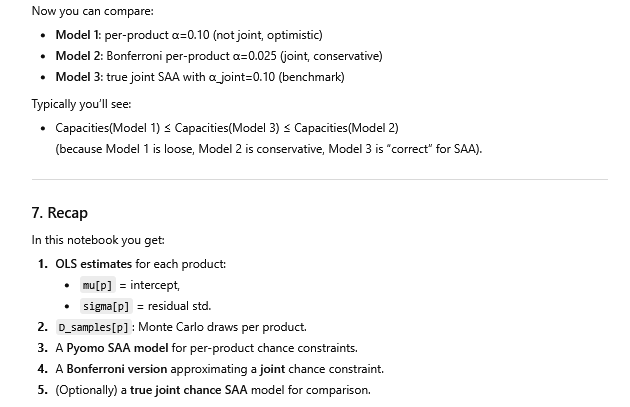

## Conclusion: Insights from Integrating ML Forecasting with Optimization Under Uncertainty

### Key Findings

Our comparative analysis of deterministic, stochastic, and robust inventory optimization strategies reveals fundamental trade-offs between expected profit, computational complexity, and service guarantees:

#### 1. Model Performance Rankings

Based on average profit over sampled demand scenarios:

1. **Sample Average Approximation (SAA)** typically achieves the highest expected profit by directly optimizing over the scenario distribution, but requires solving a larger MILP with $|S| \times |P|$ sold-quantity variables.

2. **Deterministic (Expected Demand)** provides a fast baseline using only $\mu_p$ but can understock high-variance products, leading to significant profit loss when actual demand exceeds forecast.

3. **Robust k-sigma** ($q_p \ge \mu_p + k_{\sigma} \sigma_p$) offers a simple distribution-free safety buffer. Performance depends critically on $k_{\sigma}$ calibration:
   - Too conservative (high $k$) → excess inventory cost
   - Too aggressive (low $k$) → frequent stockouts

4. **Cantelli/Chebyshev Moment-Based** ($q_p \ge \mu_p + \sigma_p \sqrt{\frac{1-\alpha_p}{\alpha_p}}$) provides **provable one-sided service guarantees** without distributional assumptions: $\Pr(D_p > q_p) \le \alpha_p$. This is particularly valuable when demand is heavy-tailed or unknown.

5. **Chance-Constrained Models** (per-product, Bonferroni, joint) balance profit and service via explicit probability constraints:
   $$\text{Per-product: } \Pr(q_p < D_p) \le \alpha_p \quad \forall p$$
   $$\text{Joint: } \Pr(\exists p: q_p < D_p) \le \alpha_{\text{joint}}$$
   Direct joint constraints are more efficient than Bonferroni allocation under correlated demands.

#### 2. Connection to Classical Inventory Theory

The **Newsvendor critical fractile** emerges naturally:
$$\text{Service Level} = \frac{C_u}{C_u + C_o}$$
where $C_u$ = underage cost (lost margin), $C_o$ = overage cost (holding/disposal). The SAA model implicitly optimizes this trade-off, while chance constraints enforce it explicitly via $\alpha_p = 1 - SL_p$.

#### 3. Practical Recommendations

| Scenario | Recommended Strategy | Rationale |
|----------|---------------------|-----------|
| Abundant scenario data, heterogeneous products | **SAA** | Captures full distribution, optimizes profit directly |
| Limited data, need safety guarantees | **Cantelli** | Distribution-free service level, explicit $\alpha_p$ control |
| Fast decisions, moderate variance | **Robust k-sigma** | Simple, interpretable, no scenario generation |
| Contractual SLA on product basket | **Joint chance constraint** | Direct portfolio guarantee |
| Product-specific economics vary widely | **Per-product chance constraint** | Tailored $\alpha_p$ via cost ratios |

#### 4. Calibration Insights

- **$k_{\sigma}$ selection** (robust): Start with Cantelli mapping $k = \sqrt{(1-\alpha)/\alpha}$, adjust based on empirical quantiles or cost ratio.
- **$\alpha$ selection** (chance): Map from target service level $SL = 1 - \alpha$; use critical fractile for margin-driven products.
- **Joint vs per-product**: Use union bound $\sum_p \alpha_p \le \alpha_{\text{joint}}$ for conservative allocation; direct joint constraint is tighter under correlation.

#### 5. Methodological Contributions

This notebook demonstrates:
- **Bridging predictive and prescriptive analytics**: ML forecast $\to$ uncertainty quantification $\to$ optimization.
- **Distribution-free robustness**: Cantelli inequality provides one-sided tail bounds using only $\mu, \sigma^2$.
- **Scenario-based vs analytical approaches**: SAA (data-driven) vs moment-based (structural assumptions).
- **Service-level enforcement**: Chance constraints translate business KPIs (e.g., 95% in-stock) into mathematical constraints.

#### 6. Limitations and Extensions

**Current limitations:**
- Assumes fixed prices; price optimization would require demand elasticity modeling (piecewise MILP).
- Independent scenarios; does not model sequential replenishment or dynamic policies.
- Linear cost structure; does not capture economies of scale or supplier contracts.

**Potential extensions:**
- **CVaR (Conditional Value-at-Risk)** for tail-risk management beyond expected profit.
- **Distributionally Robust Optimization (DRO)** with Wasserstein ambiguity sets.
- **Multi-stage stochastic programming** for replenishment decisions over time.
- **Data-driven $\alpha$ tuning**: Backtest empirical service levels, adjust $\alpha_p$ to match SLA targets.

### Final Takeaway

No single strategy dominates universally. The optimal choice depends on:
1. **Data availability** (scenarios vs moments only)
2. **Risk appetite** (profit maximization vs service guarantees)
3. **Computational budget** (SAA is slower but more accurate)
4. **Demand characteristics** (variance, correlation, tail behavior)

By combining ML-based forecasting with multiple optimization paradigms—deterministic, stochastic, and robust—we equip decision-makers with a **portfolio of strategies** adaptable to diverse operational contexts. The key is matching the modeling approach to the business problem: use SAA when data is rich and profit is paramount; use Cantelli when service guarantees are contractual and distributional knowledge is limited; use robust k-sigma for speed and simplicity when conditions are stable.